# Markovic

This notebook shows how to construct an efficient frontier of stocks based on mean variance optimization. 

### Variables

$$
\begin{equation}
C : \textrm{number of stocks}\\
T : \textrm{number of time observations} \\
\boldsymbol{\mu} : \textrm{mean stock return (C x 1)} \\
\boldsymbol{\Sigma} : \textrm{covariance matrix of returns (C x C)} \\
\mu_{targ} : \textrm{target mean return}
\end{equation}
$$

### Global Minimum Variance Portfolio

The weights, mean, and variance of the global minimum variance portfolio are
$$
\begin{equation}
\boldsymbol{w}_{gmv} = \frac{1}{\iota' \Sigma^{-1} \iota} \Sigma^{-1} \iota 
= \frac{\Sigma^{-1} \iota }{C}\\
\mu_{gmv} = \frac{1}{\iota' \Sigma^{-1} \iota}\mu' \Sigma^{-1} \iota 
= \frac{B}{C}\\
\sigma_{gmv}^2 = \frac{1}{\iota' \Sigma^{-1} \iota}
= \frac{1}{C}
\end{equation}
$$


### Efficient Frontier

The efficient frontier is defined as a linear combination of two portfolios. 
$$
\begin{equation}
\boldsymbol{w} = \lambda \boldsymbol{w}_{mu} + (1-\lambda) \boldsymbol{w}_{gmv} \\
\lambda = \frac{BC\mu_{targ}-B^2}{AC-B^2} \\
\textrm{where}\\
A = \mu' \Sigma^{-1} \mu\\
B = \mu' \Sigma^{-1} \iota\\
C = \iota' \Sigma^{-1} \iota\\
\end{equation} 
$$


In [1]:
from pathlib import Path
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns


In [2]:
def preprocess_column_name(column_name):
    column_name = column_name.title().replace(' ','').strip()
    return column_name


## Data Extraction 

### 1. Tickers



In [3]:
rawTickerDataPath = Path('data') / 'nasdaq_screener_1612565816157.csv'
processedTickerDataPath = Path('data') / 'tickers.csv'
selectedColumns = ['Symbol', 'Name', 'MarketCap', 'Country', 'Sector', 'Industry']

if not processedTickerDataPath.exists():
    print('- load raw ticker data')
    tickersDF = pd.read_csv(rawTickerDataPath)
    print('- process raw ticker data')
    tickersDF.columns = [preprocess_column_name(e) for e in tickersDF.columns]
    tickersDF = tickersDF[selectedColumns]
    print('- save processed ticker table')
    # tickersDF.to_csv(processedTickerDataPath, index=False)
else:
    print('load processed ticker table')
    tickersDF = pd.read_csv(processedTickerDataPath)


load processed ticker table


### 2. Prices

In [4]:
pricesDataPath = Path('data') / 'prices.csv'
numCompanies = 5

if not pricesDataPath.exists():
    print('get returns from yahoo')
    tickers = tickersDF['Symbol'].tolist()
    tickers = [e for e in tickers if '^' not in e or '/' not in e]
    pricesDF = yf.download( 
    tickers = ' '.join(tickers[:numCompanies]),
    period = "5y",
    interval = "1d",
    group_by = 'ticker',
    # auto_adjust = True,
    prepost = False,
    threads = True,
    proxy = None
    )
    # pricesDF.to_csv(pricesDataPath, index=False)
else:
    print('load downloaded returns table')
    pricesDF = pd.read_csv(pricesDataPath, header =[0,1])

pricesDF.head(2)


load downloaded returns table


BATL                                  AIRI                    ...   ASM  \
  Open High Low Close Adj Close Volume  Open  High   Low Close  ...   Low   
0  NaN  NaN NaN   NaN       NaN    NaN  6.09  6.09  5.85  5.99  ...  1.36   
1  NaN  NaN NaN   NaN       NaN    NaN  6.10  6.10  5.83  5.83  ...  1.36   

                           BKTI                                     
  Close Adj Close  Volume  Open  High   Low Close Adj Close Volume  
0  1.39      1.39  282300  5.17  5.20  5.02  5.11  4.334165  10800  
1  1.42      1.42  253400  5.25  5.25  5.05  5.19  4.402020    600  

[2 rows x 180 columns]

## Data Analysis

### 1. Tickers : Industry Analysis

In [5]:
print(f"""
Number of unique Sectors : {tickersDF.Sector.unique().size}
Number of unique Industries : {tickersDF.Industry.unique().size}
""")


Number of unique Sectors : 13
Number of unique Industries : 62



### 2. Prices

In [6]:
pricesDF.columns = pd.MultiIndex.from_tuples(pricesDF.columns.swaplevel())
pricesDF = pricesDF['Adj Close']
pricesDF = pricesDF.T[pricesDF.isnull().sum().eq(0)].T
pricesDF.head(2)

,AIRI,BDL,ATNM,AWX,BCV,AUMN,AEF,AXU,BDR,AMPE,...,AMS,ARMP,AIM,ACU,AE,AINC,APT,BGI,ASM,BKTI
0,5.99,17.965443,60.299999,1.96,12.048647,0.74,4.583220,1.10,0.42,3.97,...,2.20,442.399994,73.919998,15.293143,32.563530,45.500000,1.94,0.48,1.39,4.334165
1,5.83,18.296040,58.200001,1.96,12.074997,0.80,4.612601,1.17,0.41,4.10,...,2.15,459.200012,79.199997,15.347281,33.815289,45.799999,1.99,0.48,1.42,4.402020


In [7]:
print(f"""
number of time steps: {pricesDF.shape[0]}
number of companies: {pricesDF.shape[1]}
number of companies with full history: {pricesDF.isnull().sum().eq(0).sum()}
number of companies with no history: {pricesDF.notnull().sum().eq(0).sum()}
""")



number of time steps: 1259
number of companies: 24
number of companies with full history: 24
number of companies with no history: 0



## Get stock prices and Returns

In [8]:
returnsDF = pricesDF.pct_change().iloc[1:]
logReturnsDF = np.log(1+returnsDF)

p = pricesDF.to_numpy() # prices
r = returnsDF.to_numpy() # returns
r_log = np.log(1+r) # log returns

T, C = p.shape # time periods, number of companies

u = r_log.mean(0)
Sigma = np.cov(r_log.T)
iota = np.ones((C,1))


### Realised returns

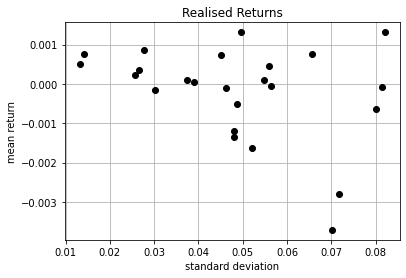

In [9]:
vol = np.sqrt(Sigma.diagonal())
x = vol
y = u

plt.plot(x, y, 'o', color='black')
plt.xlabel('standard deviation')
plt.ylabel('mean return')
plt.title('Realised Returns')
plt.grid()
plt.show()


### Efficient Frontier

Creating the efficient frontier plot

In [10]:
A = np.matmul(np.matmul(u.T, np.linalg.inv(Sigma)), u)
B = np.matmul(np.matmul(u.T, np.linalg.inv(Sigma)), iota)
C = np.matmul(np.matmul(iota.T, np.linalg.inv(Sigma)), iota)
D = np.matmul(np.matmul(iota.T, np.linalg.inv(Sigma)), u)

w_gmv = 1 / C * np.matmul(np.linalg.inv(Sigma), iota).reshape(-1,1)
u_gmv = B / C
std_gmv = np.sqrt(1 / C)

w_mu = 1 / D * np.matmul(np.linalg.inv(Sigma), u).reshape(-1,1)


In [11]:
print(f"""
Global Minimum Variance Portfolio
mean : {u_gmv[0][0]}
std : {std_gmv[0][0]}
""")


Global Minimum Variance Portfolio
mean : 0.00048185997703882475
std : 0.010095981257257157



In [12]:
c = 1.5
x = []
y = []
for u_targ in np.linspace(1/c*min(u), c*max(u), 200).tolist():
    _lambda = (B * C * u_targ - B * B) / (A * C - B * B)
    w = _lambda * w_mu + (1-_lambda) * w_gmv
    sigma = np.sqrt(np.matmul(np.matmul(w.T, Sigma), w))[0][0]
    x.append(sigma)
    y.append(u_targ)


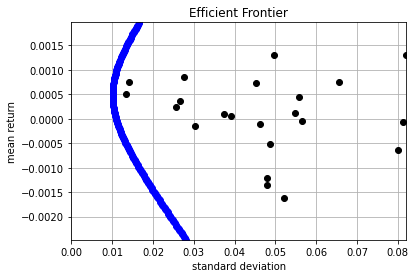

In [13]:
# plt.style.use('seaborn-whitegrid')    
vol = np.sqrt(Sigma.diagonal()).tolist()
min_sigma = min(x + vol)
max_sigma = max(x + vol)
min_return = min(y)
max_return = max(y)
plt.plot(x, y, 'o', color='blue')
x = vol
y = u
plt.plot(x, y, 'o', color='black')
plt.xlabel('standard deviation')
plt.ylabel('mean return')
plt.xlim([0, max_sigma])
plt.ylim([min_return, max_return])
plt.title('Efficient Frontier')
plt.grid()
plt.show()


## Principal Component Analysis (PCA)

Investigate the effect of applying PCA on the covariance matrix.

### - Stocks are highly correlated

/home/bart/.local/lib/python3.8/site-packages/pandas/plotting/_matplotlib/tools.py:400: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():


(0.0, 1.0)

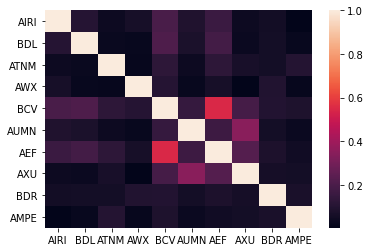

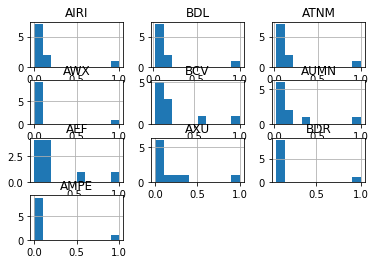

In [14]:
numStocks = 10

sns.heatmap(returnsDF[returnsDF.columns[:numStocks]].corr());
returnsDF[returnsDF.columns[:numStocks]].corr().hist();
plt.xlim([0,1])

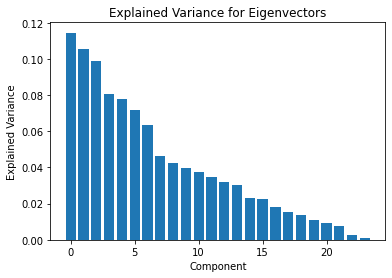

In [15]:
eigenValues, _ = np.linalg.eigh(Sigma)
eigenValues = np.flip(eigenValues)
explainedVariance = eigenValues / sum(eigenValues)
plt.bar(list(range(len(explainedVariance))), explainedVariance);
plt.title('Explained Variance for Eigenvectors');
plt.xlabel('Component');
plt.ylabel('Explained Variance');

In [19]:
def PCA(Sigma, numComponents):
    eigenValues, eigenVectors = np.linalg.eigh(Sigma)
    eigenValues = np.flip(eigenValues)
    eigenValues[numComponents:] = 0
    Q = np.flip(eigenVectors, 1)
    D = np.diag(eigenValues)
    ReducedSigma = np.matmul(np.matmul(Q, D), Q.T)
    np.fill_diagonal(ReducedSigma, np.diag(Sigma))
    return ReducedSigma

numComponents = 1
Sigma = returnsDF.cov()
ReducedSigma = pd.DataFrame(PCA(Sigma, numComponents=numComponents), columns=Sigma.columns, index=Sigma.index)
# ReducedSigma, Sigma